# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

Загрузим необходимые библиотеки:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from sklearn.dummy import DummyRegressor
from catboost import CatBoostRegressor

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder

from sklearn.metrics import mean_squared_error, make_scorer

Зададим параметры вывода в оформительских целях:

In [2]:
pd.set_option('display.float_format', '{:,.2f}'.format)
sns.set(rc={'figure.figsize':(17,4)})

Прочитаем данные из файла `*.csv`

In [3]:
data = pd.read_csv('.\\datasets\\autos.csv',  sep=',')

### Обзор данных
Краткий обзор загруженных данных:

In [4]:
data.head(2)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [6]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,"354,369.00","354,369.00","354,369.00","354,369.00","354,369.00","354,369.00","354,369.00"
mean,"4,416.66","2,004.23",110.09,"128,211.17",5.71,0.00,"50,508.69"
std,"4,514.16",90.23,189.85,"37,905.34",3.73,0.00,"25,783.10"
min,0.00,"1,000.00",0.00,"5,000.00",0.00,0.00,"1,067.00"
25%,"1,050.00","1,999.00",69.00,"125,000.00",3.00,0.00,"30,165.00"
50%,"2,700.00","2,003.00",105.00,"150,000.00",6.00,0.00,"49,413.00"
75%,"6,400.00","2,008.00",143.00,"150,000.00",9.00,0.00,"71,083.00"
max,"20,000.00","9,999.00","20,000.00","150,000.00",12.00,0.00,"99,998.00"


Оценим количество пропусков по столбцам:

In [7]:
pd.DataFrame(round((data.isna().mean()*100),2)).style.background_gradient('coolwarm')

,0
DateCrawled,0.000000
Price,0.000000
VehicleType,10.580000
RegistrationYear,0.000000
Gearbox,5.600000
Power,0.000000
Model,5.560000
Kilometer,0.000000
RegistrationMonth,0.000000
FuelType,9.280000


Описание признаков в соответствии с исходными данными:

- `DateCrawled` — дата скачивания анкеты из базы, строковый параметр, для моделирования не требуется, следовательно не требует и обработки;
- `VehicleType` — тип автомобильного кузова, ~**37.5 тысяч** пропусков;
- `RegistrationYear` — год регистрации автомобиля, пропуски отсутствуют, есть невозможны выбросы от 1000 года до 9999, подлежит исправлению;
- `Gearbox` — тип коробки передач, ~**20 тысяч** пропусков;
- `Power` — мощность (л. с.), пропуски отсутствуют;
- `Model` — модель автомобиля, ~**20 тысяч** пропусков;
- `Kilometer` — пробег (км), пропуски отсутствуют;
- `RegistrationMonth` — месяц регистрации автомобиля, пропуски отсутствуют;
- `FuelType` — тип топлива, ~**33 тысячи** пропусков;
- `Brand` — марка автомобиля, пропуски отсутствуют;
- `NotRepaired` — была машина в ремонте или нет, ~**71 тысяча** пропусков;
- `DateCreated` — дата создания анкеты, строковый параметр, для моделирования не требуется, следовательно не требует и обработки;
- `NumberOfPictures` — количество фотографий автомобиля, все значения равны 0, не требуется и подлежит удалению;
- `PostalCode` — почтовый индекс владельца анкеты (пользователя), по сути - описывает географию объявлений, и может иметь смысл в формате кластеризации, но в рамках данной задачи при использовании напрямую может вызывать ненужные ошибки;
- `LastSeen` — дата последней активности пользователя, для моделирования не требуется, следовательно не требует и обработки;

Целевой признак
- `Price` — цена (евро)

### Обработка пропусков

Для определения стратегии заполнения пропусков, рассмотрим сводную таблицу по брендам:

In [8]:
data.pivot_table(
    index=['Brand'],
    values=['Price'],
    aggfunc=['median', 'count']
).sort_values(('count', 'Price'), ascending=False).head(3)

,median,count
,Price,Price
Brand,,
volkswagen,"2,699.00",77013
opel,"1,500.00",39931
bmw,"4,799.00",36914


Первое место уверенно занимает бренд ***Volkswagen***, расммотрим распределение по моделям:

In [9]:
data.pivot_table(
    index=['Brand', 'Model'],
    values=['Price'],
    aggfunc=['median', 'count']
).loc[['volkswagen']].sort_values(('count', 'Price'), ascending=False).head(11)

median  count
                          Price  Price
Brand      Model                      
volkswagen golf        2,450.00  29232
           polo        1,350.00  13066
           passat      3,000.00  10146
           transporter 5,300.00   4822
           touran      5,900.00   3470
           lupo        1,299.00   2594
           caddy       5,100.00   1595
           sharan      3,500.00   1483
           bora        2,350.00    872
           beetle      4,999.00    815
           other       3,000.00    768

Наблюдается значение модели **other**, но оно встречается в почти 40 раз реже, чем наиболее популярная модель **golf**.

Аналогичная зависимость наблюдается и по другим брендам.

In [10]:
data['Model'].value_counts().head(3)

golf     29232
other    24421
3er      19761
Name: Model, dtype: int64

При этом, количество значений **other** в общем по данным составляет значительное количество (**24421**). Следовательно, заполнение пропусков этим значением приведёт к значительным искажениям. 

Принимаем метод заполнения модой с группировкой по бренду:

    df['X'] = df.groupby('Y')['X'].transform(lambda x: x.fillna(x.mode()[0])

Напрямую применение этого метода не срабатывает, так как в данных есть бренд с полностью отсутсвующим значением столбца `Model`:

In [11]:
set(data['Brand'].value_counts().to_dict()) \
- set(data.dropna(subset=['Model'])['Brand'].value_counts().to_dict())

{'sonstige_autos'}

Заменим все значения столбца `Model` бренда ***sonstige_autos*** (нем. "Другие автомобили") на значение **other**, так как в данном случае оно подходит как нельзя лучше.

In [12]:
data.loc[data['Brand'] == "sonstige_autos", 'Model'] = "other"

Воспользоуемся вышеупомянутым способом для заполнения таких параметров как модель, тип КПП и тип топлива:

In [13]:
data[['Model', 'Gearbox', 'FuelType']] = (
    data.groupby('Brand')[['Model',
                           'Gearbox',
                           'FuelType']].transform(lambda x: x.fillna(x.mode()[0]))
)

Аналогично заполним и значение типа кузова `VehicleType`, но опираясь уже на модель:

In [14]:
data['VehicleType'] = (
    data.groupby('Model')['VehicleType'].transform(lambda x: x.fillna(x.mode()[0]))
)

Значение `NotRepaired` поставим равным *no*, так как взаимосвязь между пребыванием в ремонте и остальными доступными данными не наблюдается.  

In [15]:
data['NotRepaired'].fillna('no', inplace=True)

И отбросим ненужные столбцы:

In [16]:
data.drop(labels=['DateCrawled',
                  'NumberOfPictures',
                  'LastSeen',
                  'DateCreated',
                  'PostalCode',
                  'RegistrationMonth'], axis=1, inplace=True)

In [17]:
data.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,480,sedan,1993,manual,0,golf,150000,petrol,volkswagen,no
1,18300,coupe,2011,manual,190,a4,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,no
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


### Борьба с выбросами


Рассмотрим данные на предмет выбросов, воспользовавшись для этого `scatterplot`, на котором точно выбросы будут даже заметнее, чем на классической гистограмме.

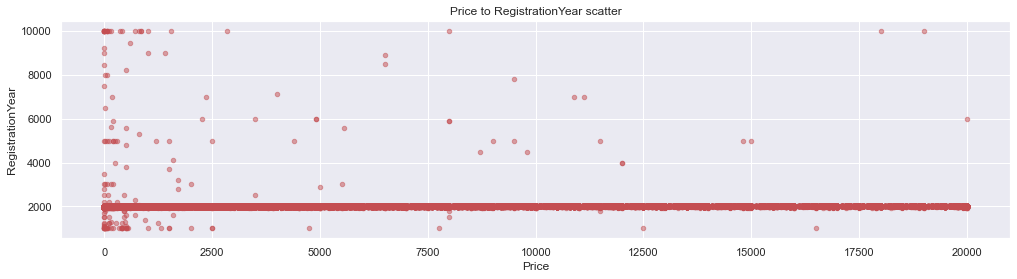

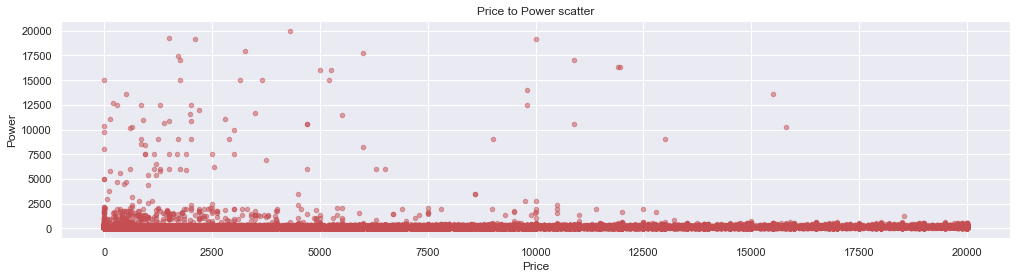

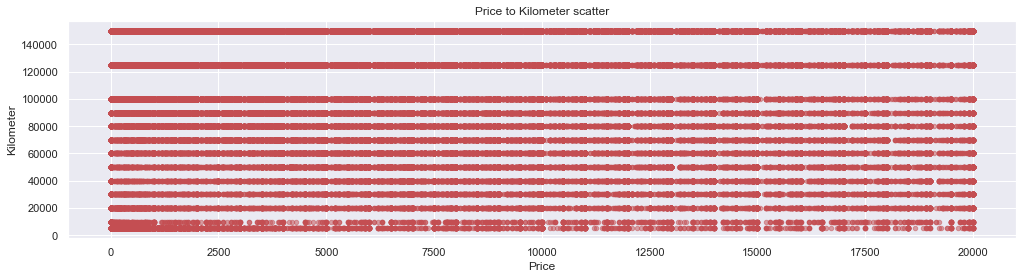

In [18]:
for col in data.select_dtypes(exclude=['object']).columns.to_list()[1:]:
    ax = data.plot(
        kind='scatter',
        x='Price',
        y=f'{col}',
        color="r",
        alpha=0.5,
        title=f'Price to {col} scatter',
        grid=True,
        figsize=(17,4)
    )

Наглядно видны выбросы в столбцах `Power` и `RegistrationYear`. Границы выбросов определим из межквартильного расстояния из расчёта **3*IQR**:

In [19]:
def iqr_max(column):
    iqr = column.quantile(q=0.75) - column.quantile(q=0.25)
    maxi = column.quantile(q=0.75)+3.0*iqr
    if maxi <= column.max():
        return maxi
    else:
        return column.max()        
        
def iqr_min(column):
    iqr = column.quantile(q=0.75) - column.quantile(q=0.25)
    mini = column.quantile(q=0.25)-3.0*iqr
    if mini >= column.min():
        return mini
    else:
        return column.min()

Как пример:

In [20]:
print('Диапазон нормальных значений столбца {} составляет от {} снизу до {} сверху'
      .format(data['Power'].name, iqr_min(data['Power']), iqr_max(data['Power'])))

print('Диапазон нормальных значений столбца {} составляет от {} снизу до {} сверху'
      .format(data['RegistrationYear'].name, iqr_min(data['RegistrationYear']), iqr_max(data['RegistrationYear'])))

Диапазон нормальных значений столбца Power составляет от 0 снизу до 365.0 сверху
Диапазон нормальных значений столбца RegistrationYear составляет от 1972.0 снизу до 2035.0 сверху


Обрежем данные по этим значениям, кроме значения столбца `RegistrationYear`, который заведомо не может быть больше текущего года.

In [21]:
good_data = data.loc[(data['Power'] >= iqr_min(data['Power'])) & 
                     (data['Power'] <= iqr_max(data['Power'])) &
                     (data['RegistrationYear'] >= iqr_min(data['RegistrationYear'])) & 
                     (data['RegistrationYear'] <= datetime.now().year)]

В результате чего, получаем обновлёный DataFrame уменьшенного размера, суммарные потери (процент отброшенных строк) составит:

In [22]:
print(round(((data.shape[0] - good_data.shape[0]) / data.shape[0])*100, 2), '%')

0.83 %


, что более чем приемлемо. Построим scatterplot уже по обновлённым данным.

C:\Users\femt0\miniforge3\lib\site-packages\IPython\core\pylabtools.py:134: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


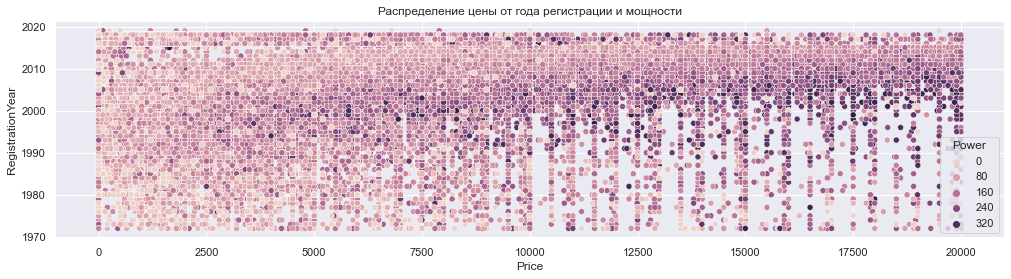

In [48]:
sns.scatterplot(
    data=good_data,
    x='Price',
    y='RegistrationYear',
    hue='Power',
    legend='auto'
)
plt.title('Распределение цены от года регистрации и мощности')
plt.show()

Распределение без выбросов более наглядно показывает:

- более мощные автомобили находятся ближе к правой части графика, т.е. высоким ценам;
- чем машина старее (год регистрации старше), тем реже они встречаются среди дорогих.

Выделим целевой признак для дальнешей работы:

In [24]:
X = good_data.copy()
y = X.pop('Price')

И разделим на тестовую и валидационную выборки:

In [25]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=13)

### Масштабирование и кодирование признаков

Во избежание путаницы, разделим данные на категориальные и численные значения, и обработаем их отдельно.

1) Закодируем категориальные признаки методом `OrdinalEncoder()`, чтобы с ними могли работать все модели, а не только `CatBoost`:

In [26]:
X_train_cat = X_train.select_dtypes(include='object')
X_valid_cat = X_valid.select_dtypes(include='object')

encoder = OrdinalEncoder()
encoder.fit(X_train_cat)

X_train_ordinal = pd.DataFrame(
    encoder.transform(X_train_cat).astype('int'),
    columns=X_train_cat.columns,
    index=X_train_cat.index)

X_valid_ordinal = pd.DataFrame(
    encoder.transform(X_valid_cat).astype('int'),
    columns=X_valid_cat.columns,
    index=X_valid_cat.index)

X_train_ordinal.head()

,VehicleType,Gearbox,Model,FuelType,Brand,NotRepaired
23873,4,1,116,2,38,0
314100,0,0,222,2,38,0
219210,5,1,83,6,24,0
193995,5,1,102,6,10,0
304980,7,1,101,6,31,0


2) Обработаем численные значение при помощи `StandardScaler()`:

In [27]:
X_train_num = X_train.select_dtypes(exclude='object')
X_valid_num = X_valid.select_dtypes(exclude='object')

scaler = StandardScaler()
scaler.fit(X_train_num)

X_train_scaled = pd.DataFrame(
    scaler.transform(X_train_num),
    columns=X_train_num.columns,
    index=X_train_num.index)

X_valid_scaled = pd.DataFrame(
    scaler.transform(X_valid_num),
    columns=X_valid_num.columns,
    index=X_valid_num.index)

X_train_scaled.head()

,RegistrationYear,Power,Kilometer
23873,0.54,0.55,0.57
314100,-0.04,-0.02,0.57
219210,-1.80,-0.50,-0.09
193995,-0.92,-0.75,-0.09
304980,0.54,-0.42,0.57


И сошьём полученное обратно:

In [28]:
X_train = pd.concat([X_train_ordinal, X_train_scaled], axis=1)
X_valid = pd.concat([X_valid_ordinal, X_valid_scaled], axis=1)
X_train.head()

,VehicleType,Gearbox,Model,FuelType,Brand,NotRepaired,RegistrationYear,Power,Kilometer
23873,4,1,116,2,38,0,0.54,0.55,0.57
314100,0,0,222,2,38,0,-0.04,-0.02,0.57
219210,5,1,83,6,24,0,-1.80,-0.50,-0.09
193995,5,1,102,6,10,0,-0.92,-0.75,-0.09
304980,7,1,101,6,31,0,0.54,-0.42,0.57


### Вывод

После всех преобразований данные готовы к моделированию, потери размера данных составили менее процента.

## Обучение моделей

В связи с отсутсвием параметра `squared=False` в подгруженной версии `mean_squared_error()`, добавим простую фукнцию `rmse()`

In [29]:
def rmse(model, X_valid, y_valid):
    y_pred = model.predict(X_valid)
    mse = mean_squared_error(y_valid, y_pred)
    return mse**0.5

Результаты работы всех моделей будут собраны в новый DataFrame().

In [30]:
results = pd.DataFrame(columns=['RMSE', 'fit_time', 'predict_time'])

### DummyRegressor()

Первым делом создадим baseline модель `DummyRegressor()`. Измерение времени будет выполняться с использованием `datetime.now()` вместо `%%time` для возможности сохранения его в таблицу.

In [31]:
dummy_model = DummyRegressor()

time_start = datetime.now()

dummy_model.fit(X_train, y_train)

time_mid = datetime.now()

dummy_model.predict(X_valid)
time_end = datetime.now()

И добавим результат в таблицу:

In [32]:
results.loc['DummyRegressor'] = [rmse(dummy_model, X_valid, y_valid),
                                 (time_mid - time_start).total_seconds(),
                                 (time_end - time_mid).total_seconds()]

### LinearRegression()

Проверим модель линейной регрессии

In [33]:
linear_model = LinearRegression()

time_start = datetime.now()

linear_model.fit(X_train, y_train)

time_mid = datetime.now()

linear_model.predict(X_valid)

time_end = datetime.now()

Результат также добавим в таблицу

In [34]:
results.loc['LinearRegression'] = [rmse(linear_model, X_valid, y_valid),
                                   (time_mid - time_start).total_seconds(),
                                   (time_end - time_mid).total_seconds()]

### RandomForestRegressor()

Для модели случайного леса в начале необходимо определить наилучшие гиперпараметры:

(в рамках конкретной тетради данный код закомментирован, как слишком долго выполняющийся, наилучшие гиперпараметры были подобраны на другом устройстве)

In [35]:
#rfr_clf = RandomForestRegressor()
#rfr_parameters = {'n_estimators': range (100, 200, 10),
#                  'max_depth': range (15,26, 1),
#                  'random_state': [13],
#                  'n_jobs': [-1]
#                 }

In [36]:
#%%time
#grid_rfr = GridSearchCV(rfr_clf,
#                        rfr_parameters,
#                        scoring='neg_root_mean_squared_error',
#                        cv=5)
#grid_rfr.fit(X_train, y_train)
#grid_rfr.best_params_

Обучим модель с полученными гиперпараметрами:

In [37]:
#rfr_model = RandomForestRegressor(**grid_rfr_rough.best_params_)
rfr_model = RandomForestRegressor(max_depth=20, n_estimators=150, n_jobs=-1, random_state=13)

time_start = datetime.now()

rfr_model.fit(X_train, y_train)

time_mid = datetime.now()

rfr_model.predict(X_valid)

time_end = datetime.now()

In [38]:
results.loc['RandomForestRegressor'] = [rmse(rfr_model, X_valid, y_valid),
                                        (time_mid - time_start).total_seconds(),
                                        (time_end - time_mid).total_seconds()]

### CatBoostRegressor()

Воспользуемся одним из вариантов реализации градиентного спуска, для этого восстановим версию *X_train* и *X_valid* с незакодированными категориальными признаками:

In [46]:
cat_feat = X_train_cat.columns.tolist()

X_train_с = pd.concat([X_train_cat, X_train_scaled], axis=1)
X_valid_с = pd.concat([X_valid_cat, X_valid_scaled], axis=1)

X_train_с[cat_feat] = X_train_с[cat_feat].astype('category')
X_valid_с[cat_feat] = X_valid_с[cat_feat].astype('category')

X_train_с.head(2)

,VehicleType,Gearbox,Model,FuelType,Brand,NotRepaired,RegistrationYear,Power,Kilometer
23873,sedan,manual,golf,gasoline,volkswagen,no,0.54,0.55,0.57
314100,bus,auto,touran,gasoline,volkswagen,no,-0.04,-0.02,0.57


In [47]:
cat_model = CatBoostRegressor(learning_rate=1,
                              depth=6,
                              loss_function='RMSE',
                              random_seed=13,
                              verbose=50)

time_start = datetime.now()

cat_model.fit(X_train_с,
              y_train,
              cat_features=cat_feat)

time_mid = datetime.now()

cat_model.predict(X_valid_с)

time_end = datetime.now()

0:	learn: 2695.9310179	total: 246ms	remaining: 4m 6s
50:	learn: 1805.6631172	total: 5.27s	remaining: 1m 38s
100:	learn: 1739.9994365	total: 9.93s	remaining: 1m 28s
150:	learn: 1701.2991622	total: 15.1s	remaining: 1m 25s
200:	learn: 1672.8342859	total: 20.3s	remaining: 1m 20s
250:	learn: 1648.4462084	total: 25.2s	remaining: 1m 15s
300:	learn: 1628.9323545	total: 30.3s	remaining: 1m 10s
350:	learn: 1614.3423487	total: 35.3s	remaining: 1m 5s
400:	learn: 1600.5684161	total: 40.4s	remaining: 1m
450:	learn: 1587.1033375	total: 46.1s	remaining: 56.1s
500:	learn: 1575.9271884	total: 51.5s	remaining: 51.3s
550:	learn: 1566.4284394	total: 56.8s	remaining: 46.3s
600:	learn: 1557.4007263	total: 1m 1s	remaining: 41.1s
650:	learn: 1548.1109274	total: 1m 7s	remaining: 35.9s
700:	learn: 1538.2969018	total: 1m 12s	remaining: 30.8s
750:	learn: 1531.2274232	total: 1m 17s	remaining: 25.7s
800:	learn: 1523.5065158	total: 1m 22s	remaining: 20.5s
850:	learn: 1515.5804729	total: 1m 27s	remaining: 15.3s
900:	l

In [ ]:
results.loc['CatBoostRegressor_CAT'] = [rmse(cat_model, X_valid_с, y_valid),
                                        (time_mid - time_start).total_seconds(),
                                        (time_end - time_mid).total_seconds()]

Сравним результат с данными с предварительно закодированным категориальными признаками:

In [ ]:
cat_model = CatBoostRegressor(learning_rate=1,
                              depth=6,
                              loss_function='RMSE',
                              random_seed=13,
                              verbose=50)

time_start = datetime.now()

cat_model.fit(X_train,
              y_train)

time_mid = datetime.now()

cat_model.predict(X_valid)

time_end = datetime.now()

In [ ]:
results.loc['CatBoostRegressor'] = [rmse(cat_model, X_valid, y_valid),
                                        (time_mid - time_start).total_seconds(),
                                        (time_end - time_mid).total_seconds()]

### lightgbm()

Воспользуемся другим вариантом градиентного спуска за авторством Microsoft, для чего сначала зададим параметры:

In [ ]:
lgb_model = lgb.LGBMRegressor(
    boosting_type='gbdt',
    max_depth=-1,
    learning_rate=0.5,
    n_estimators=100,
    random_state=13,
    n_jobs=-1
)

И обучим модель:

In [ ]:
time_start = datetime.now()

lgb_model.fit(X_train_с,
              y_train)

time_mid = datetime.now()

lgb_model.predict(X_valid_с)

time_end = datetime.now()

Также, добавим результат в таблицу:

In [ ]:
results.loc['LGBMRegressor_CAT'] = [rmse(lgb_model, X_valid_с, y_valid),
                                    (time_mid - time_start).total_seconds(),
                                    (time_end - time_mid).total_seconds()]

Аналогично, сравним результат с данными с предварительно закодированным категориальными признаками:

In [ ]:
time_start = datetime.now()

lgb_model.fit(X_train,
              y_train)

time_mid = datetime.now()

lgb_model.predict(X_valid)

time_end = datetime.now()

In [ ]:
results.loc['LGBMRegressor'] = [rmse(lgb_model, X_valid, y_valid),
                                (time_mid - time_start).total_seconds(),
                                (time_end - time_mid).total_seconds()]

### Вывод

Модели обучены, и подготовлены к анализу.

## Анализ моделей

### Анализ результатов моделирования
Просмотрим таблицу результатов моделей:

In [ ]:
results

Из неё можно вывести следующее:

- Все модели проходят проверку на адекватность, так как результат отличается от baseline модели `DummyRegressor()`;
- Модель линейно регрессии `LinearRegression()` показывает один из худших результатов, едва проходя проверку на адекватность, при этом являясь самой быстрой из всех моделей;
- Наилучший результат покаызывает модель случайного леса `RandomForestRegressor()`, при этом показывая один из худших результатов по времени тренировки модели и худшее - по времени предсказания. Также в данной таблице не учтено огромное время на поиск оптимальных гиперпараметров;
- `CatBoostRegressor()` даёт сопоставимы результат по метрике RMSE, в данном случае представлен в двух вариантах:
  - При использовании встроенных механизмов обработки категориальных данных модели - время тренировки модели более чем в **6 раз** превышает таковое у `RandomForestRegressor()`, что показывает низкую эффективность этой встроенной обработки;
  - При использовании предобработанных данных время тренировки модели большее всего на **50%**, чем `RandomForestRegressor()`, но меньше почти в **4 раза**, чем без предварительной обработки категориальных признаков;
- `LGBMRegressor()` также показывает сопоставимый результат с `RandomForestRegressor()`, при этом являясь одной из самых быстрых моделей, как по времени тренировки, так и по времени предсказаний. Встроенный алгоритм обработки категориальных признаков показал себя эффективно, сэкономив дополнительные 3 секунды времени тренировки модели.

Из вышесказанного можно резюмировать - **наилушая** для внедрения модели - это **`LGBMRegressor()`**, если пожертвовать временем тренировки - второе место занимает `CatBoostRegressor()` (в случае предварительно подготовленных данных)

Также проверим важность отдельных признаков через вызов `.feature_importances_` различных моделей (для большей равномерности значений, некоторые из них умножим на 100, а некоторые - поделим на 30):

In [ ]:
feature_importances = pd.DataFrame(index=X.columns.values,
                                   data={
                                       'randomforest': rfr_model.feature_importances_*100,
                                       'catboost': cat_model.feature_importances_,
                                       'lightgbm': lgb_model.feature_importances_/30})

In [ ]:
feature_importances

Рассмотрим данные значения в виде графика:

In [ ]:
feature_importances.plot(kind='barh',
                         figsize=(17,10),
                         title='Feature importances',
                         width=0.8)
plt.show()

Исходя из данного графика, наибольшую важность приобрёл признак **FuelType** и потом уже **Brand** и все остальные, а наименьший - пробег **Kilometer**

### Вывод

Оптимальная для внедрения модель - это **`LGBMRegressor()`**, с лучшими результатами и быстрейшем временем обучения и предсказания.